# Converting PlanetScope Imagery from Radiance to Reflectance

Planet Labs' analytic data products (both Rapideye and Dove) are reported in units of radiance: $W*m^{-2}*sr^{-1}$. That means that every pixel in an analytic tiff has a natural language interpretation: "How much light was captured over this spot of ground?"

But over the course of a day or year, the number of photons that the sun shines on the scene rises and falls. If you naively compare the radiance values of two scenes over the same spot on Earth from the same satellite but a few weeks (or even just hours!) apart, you will likely find dramatic radiance differences **even if nothing on the ground has changed!**

In addition to this variation, each of Planet Labs' 150+ satllites have small amounts of variation in their spectral filters which yields slight differences in radiance measurements, even from two satellites taking pictures of the same exact place at the same exact moment!

![Illumination](illumination.png)

To correct all this radiance variation you would have to do a lot of math using the exact location and local time of day to find the angle to the sun and sun-earth distance, then compute a solar irradiance model to estimate how many photons of each band are present in the image, and finally convolve that spectrum with the spectral response of the individual satellite to yield the number of photons of each band that are actually recorded by that sensor. Dividing by this number normalizes the measured brightness to the brightness of the sun at that time and place through that particular filter, yielding a much more comparable number: reflectance.

Top of Atmosphere Reflectance is extremely useful because it is an apples-to-apples comparable number from any satellite over any location that does not change with time of day or time of year **unless the content of the scene changes.** It is very commonly used in GIS applications which compute spectral indices such as NDVI or NDWI. 

It is so broadly useful that Planet does this math for you and provides all the coefficients necessary to convert a radiance image into a reflectance image!

$$
\begin{equation*}
\mathbf{img}_{reflectance} =  \begin{vmatrix}
a \\
b \\
c \\
d 
\end{vmatrix}
\times \mathbf{img}_{radiance}
\end{equation*}
$$


The four coefficients $a, b, c, d$ are calculated and provided with every analytic image that Planet provides and can be used as simple scaling factors to convert from radiance to reflectance. Their values change with the image's local 
time of day and time of year, and do so uniquely per satellite.

**In this guide, you'll perform a basic Radiance to Reflectance calculation on PlanetScope imagery using just a few lines of Python. Here are the steps:**

1. Download a PlanetScope image
2. Extract data from each spectral band
3. Extract the coefficients
4. Convert Radiance to Reflectance
5. Save the Reflectance
6. Apply a color scheme to visualize reflectance on a map

### Requirements
- Python 2.7 or 3+
- [Planet's Python Client](https://www.planet.com/docs/api-quickstart-examples/cli/)
- [rasterio](https://github.com/mapbox/rasterio)
- [numpy](http://www.numpy.org/)
- [matplotlib](https://matplotlib.org/)
- [Planet API Key](https://www.planet.com/account/#/), stored as environment variable `$PL_API_KEY`.
- [Planet 4-Band Imagery](https://developers.planet.com/docs/data/psscene/) with the following specifications: `item-type`: `PSOrthoTile`, `REOrthoTile`, or `PSScene`; `asset-type`: `ortho_analytic_4b`, or `basic_analytic_4b`

## Step 1. Download a PlanetScope Image 

First, you're going to download a [4-band PlanetScope satellite image](https://developers.planet.com/docs/data/psscene/) of agricultural land in California's Central Valley, captured in mid July 2017 (`item-id`: `20170623_180038_0f34`). You can do this using [Planet's Python client](https://www.planet.com/docs/api-quickstart-examples/cli/) to interact with our Data API, or by browsing [Planet Explorer](https://www.planet.com/products/explorer/), filtering for 4 Band PlanetScope scene (`PSScene`) or Planetscope ortho tile (`PSOrthoTile`), and downloading an `ortho_analytic_4b` asset.

Before you download the full image, you can [preview a thumbnail](https://www.planet.com/docs/reference/data-api/previews/) of the image via Planet's Data API. (The thumbnails are 256x256 by default, and can be scaled up by passing in a `width` parameter.) 

In [1]:
from IPython.display import Image
Image(url="https://api.planet.com/data/v1/item-types/PSScene/items/20170623_180038_0f34/thumb?width=512")

Next, you'll use [Planet's Data API](https://developers.planet.com/planetschool/searching-for-imagery-with-data-api/) to download the image.

In [ ]:
# Import helper modules
import json
import requests

In [ ]:
# Helper function to printformatted JSON using the json module
def p(data):
    print(json.dumps(data, indent=2))

In [ ]:
# Setup Planet Data API base URL
#URL = "https://api.planet.com/data/v1"
URL = "https://api.planet.com/data/v1/item-types/PSScene/items/20170623_180038_0f34"

# Setup the session
session = requests.Session()

# Authenticate
session.auth = (PLANET_API_KEY, "")

In [ ]:
# Make a GET request to the Planet Data API
res = session.get(URL)

In [ ]:
# Response status code
res.status_code

In [ ]:
# Response Body
res.text

In [ ]:
# Assign the response to a variable
geojson = res.json()

# Print response
p(geojson)

In [ ]:
geojson["_permissions"]

In [ ]:
# Get the assets link for the item
assets_url = geojson["_links"]["assets"]

# Print the assets link
print(assets_url)

In [ ]:
# Send a GET request to the assets url for the item (Get the list of available assets for the item)
res = session.get(assets_url)

# Assign a variable to the response
assets = res.json()

In [ ]:
# Print the asset types that are available
print(assets.keys())

In [ ]:
# Assign a variable to the assets we want from the item's assets
ortho_analytic_4b_xml = assets["ortho_analytic_4b_xml"]
ortho_analytic_4b = assets["ortho_analytic_4b"]


# Print the asset data
p(ortho_analytic_4b_xml)
p(ortho_analytic_4b)

### Activating Assets

Before an asset is available for download, it must be activated.

You can activate an asset by sending a POST or GET request to the asset's "activation link".

The activation usually takes a little bit of time.

In [ ]:
# Setup the activation url for a particular asset (in this case the ps3b_analytic asset)
activation_url_xml = ortho_analytic_4b_xml["_links"]["activate"]

# Send a request to the activation url to activate the item
res = session.get(activation_url_xml)

# Print the response from the activation request
# A response code of 204 means to the asset is ready to download!
p(res.status_code)

In [ ]:
# Setup the activation url for a particular asset (in this case the ps3b_analytic asset)
activation_url = ortho_analytic_4b["_links"]["activate"]

# Send a request to the activation url to activate the item
res = session.get(activation_url)

# Print the response from the activation request
# A response code of 204 means to the asset is ready to download!

p(res.status_code)

### Downloading Assets

In [ ]:
# Assign a variable to the visual asset's location endpoint
location_url = ortho_analytic_4b["location"]

# Print the location endpoint
print(location_url)

In [ ]:
# Assign a variable to the visual asset's location endpoint
location_url_xml = ortho_analytic_4b_xml["location"]

# Print the location endpoint
print(location_url_xml)

In [ ]:
# Create a function to download asset files
# Parameters: 
# - url (the location url)
# - filename (the filename to save it as. defaults to whatever the file is called originally)

def pl_download(url, filename=None):
    
    # Send a GET request to the provided location url, using your API Key for authentication
    res = requests.get(url, stream=True, auth=(PLANET_API_KEY, ""))
    # If no filename argument is given
    if not filename:
        # Construct a filename from the API response
        if "content-disposition" in res.headers:
            filename = res.headers["content-disposition"].split("filename=")[-1].strip("'\"")
        # Construct a filename from the location url
        else:
            filename = url.split("=")[1][:10]
    # Save the file
    with open('output/' + filename, "wb") as f:
        for chunk in res.iter_content(chunk_size=1024):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()

    return filename

In [ ]:
# Download the file from an activated asset's location url
pl_download(location_url)

In [ ]:
# Download the file from an activated asset's location url
pl_download(location_url_xml)

**Congratulations!** You now have two files in your `output` directory: `20170623_180038_0f34_3B_AnalyticMS.tif` and `20170623_180038_0f34_3B_AnalyticMS_metadata.xml`. The first file is a GeoTIFF, the image you requested with spatial reference data embedded. The second file is a metadata file for that image that includes the data you'll need to convert from radiance to reflectance. 

## Step 2. Extract the Data from Each Spectral Band 

In this step, you'll use [Rasterio](https://github.com/mapbox/rasterio), a Python library for reading and writing geospatial raster datasets, to open the raster image you downloaded (the .tif file). Then you'll extract the data from the red and near-infrared bands and load the band data into arrays that you can manipulate using Python's [NumPy](http://www.numpy.org/) libary. *Note: in PlanetScope 4-band images, the band order is BGRN: (1) Blue, (2) Green, (3) Red, (4) Near-infrared.*

In [3]:
import rasterio
import numpy as np

filename = "output/20170623_180038_0f34_3B_AnalyticMS.tif"

# Load red and NIR bands - note all PlanetScope 4-band images have band order BGRN
with rasterio.open(filename) as src:
    band_blue_radiance = src.read(1)
    
with rasterio.open(filename) as src:
    band_green_radiance = src.read(2)

with rasterio.open(filename) as src:
    band_red_radiance = src.read(3)

with rasterio.open(filename) as src:
    band_nir_radiance = src.read(4)

## Step 3. Extract the Coefficients

Before you can convert to reflectance, you must extract the conversion coefficients from the metadata file you downloaded (the .xml file).

In [4]:
from xml.dom import minidom

xmldoc = minidom.parse("output/20170623_180038_0f34_3B_AnalyticMS_metadata.xml")
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# XML parser refers to bands by numbers 1-4
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)

print("Conversion coefficients: {}".format(coeffs))

Conversion coefficients: {1: 1.92992290459e-05, 2: 2.0401521894e-05, 3: 2.2723104298e-05, 4: 3.35095412863e-05}


Note that the coefficients are all of order `1e-5`, and that the coefficient for NIR is significantly higher than the coefficient for blue. This is a big deal if your use case involves performing band math because a pixel with a `NIR/blue` ratio of `1.0` in the radiance image will have a `NIR/blue` ratio of `3.35/1.929=1.73` in the reflectance image!

Most spectral indices are defined in terms of reflectance, not radiance.

## Step 4: Convert Radiance to Reflectance

Radiance is measured in SI units: W/m^2. Reflectance is a ratio from 0 to 1. The conversion is performed as a simple per-band scalar multiplication:

In [5]:
# Multiply the Digital Number (DN) values in each band by the TOA reflectance coefficients
band_blue_reflectance = band_blue_radiance * coeffs[1]
band_green_reflectance = band_green_radiance * coeffs[2]
band_red_reflectance = band_red_radiance * coeffs[3]
band_nir_reflectance = band_nir_radiance * coeffs[4]

import numpy as np
print("Red band radiance is from {} to {}".format(np.amin(band_red_radiance), np.amax(band_red_radiance)))
print("Red band reflectance is from {} to {}".format(np.amin(band_red_reflectance), np.amax(band_red_reflectance)))

Red band radiance is from 0 to 24764
Red band reflectance is from 0.0 to 0.562714954835672


## Step 5. Save the Reflectance Image 

Next, you're going to save the calculated reflectance values to a new image file, making sure the new image file has the same geospatial metadata as the original GeoTIFF we downloaded.

In [6]:
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.uint16,
    count = 4)

print("Before Scaling, red band reflectance is from {} to {}".format(np.amin(band_red_reflectance),
                                                                      np.amax(band_red_reflectance)))

# Here we include a fixed scaling factor. This is common practice.
scale = 10000
blue_ref_scaled = scale * band_blue_reflectance
green_ref_scaled = scale * band_green_reflectance
red_ref_scaled = scale * band_red_reflectance
nir_ref_scaled = scale * band_nir_reflectance

print("After Scaling, red band reflectance is from {} to {}".format(np.amin(red_ref_scaled),
                                                                    np.amax(red_ref_scaled)))

# Write band calculations to a new raster file
with rasterio.open('data/reflectance.tif', 'w', **kwargs) as dst:
        dst.write_band(1, band_blue_reflectance.astype(rasterio.uint16))
        dst.write_band(2, band_green_reflectance.astype(rasterio.uint16))
        dst.write_band(3, band_red_reflectance.astype(rasterio.uint16))
        dst.write_band(4, band_nir_reflectance.astype(rasterio.uint16))

Before Scaling, red band reflectance is from 0.0 to 0.562714954835672
After Scaling, red band reflectance is from 0.0 to 5627.1495483567205


This warrants some explanation: Reflectance is generally defined as a floating point number between 0 and 1, but image file formats are much more commonly stored as unsigned integers. A common practice in the industry is to multiply the radiance value by 10,000, then save the result as a file with data type uint16.

## Step 6. Apply a Color Scheme to Visualize the Reflectance Values on the Image

In the last step, you'll use [Matplotlib](https://matplotlib.org/) to visualize the reflectance values you calculated for the PlanetScope scene.

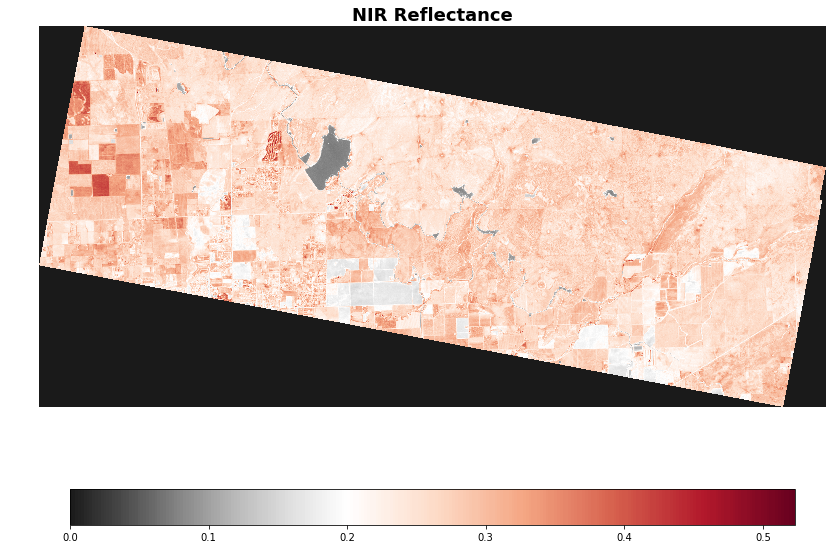

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

"""
The reflectance values will range from 0 to 1. You want to use a diverging color scheme to visualize the data,
and you want to center the colorbar at a defined midpoint. The class below allows you to normalize the colorbar.
"""

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    Credit: Joe Kington, http://chris35wills.github.io/matplotlib_diverging_colorbar/
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


# Set min/max values from reflectance range for image (excluding NAN)
min=np.nanmin(band_nir_reflectance)
max=np.nanmax(band_nir_reflectance)
mid=0.20

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

# diverging color scheme chosen from https://matplotlib.org/users/colormaps.html
# note that appending '_r' to the color scheme name reverses it!
cmap = plt.cm.get_cmap('RdGy_r')

cax = ax.imshow(band_nir_reflectance, cmap=cmap, clim=(min, max), norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max))

ax.axis('off')
ax.set_title('NIR Reflectance', fontsize=18, fontweight='bold')

cbar = fig.colorbar(cax, orientation='horizontal', shrink=0.65)

fig.savefig("data/ref-fig.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()

Looking at the NIR reflectance image, we see that the lakes and ponds appear to reflect almost no infrared light at all, but the healthy fields reflect almost 50% of the incoming infrared light!